<a href="https://colab.research.google.com/github/InesZenkri/Calculator/blob/main/of_inital_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler

In [99]:
data = pd.read_csv("initial_data.csv")
print("Data Information:")
print(data.info())
print("\nData Statistics:")
print(data.describe())
x = data.iloc[:, :-5].values
y = data.iloc[:, -5:].values

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engine speed        100 non-null    float64
 1   Engine load         100 non-null    float64
 2   Railpressure        100 non-null    float64
 3   Air supply          100 non-null    float64
 4   Crank angle         100 non-null    float64
 5   Intake pressure     100 non-null    float64
 6   Back pressure       100 non-null    float64
 7   Intake temperature  100 non-null    float64
 8   NOx                 100 non-null    float64
 9   PM 1                100 non-null    float64
 10  CO2                 100 non-null    float64
 11  PM 2                100 non-null    float64
 12  Pressure cylinder   100 non-null    float64
dtypes: float64(13)
memory usage: 10.3 KB
None

Data Statistics:
       Engine speed  Engine load  Railpressure   Air supply  Crank angle  \
co

In [100]:
#sns.pairplot(data)
#plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

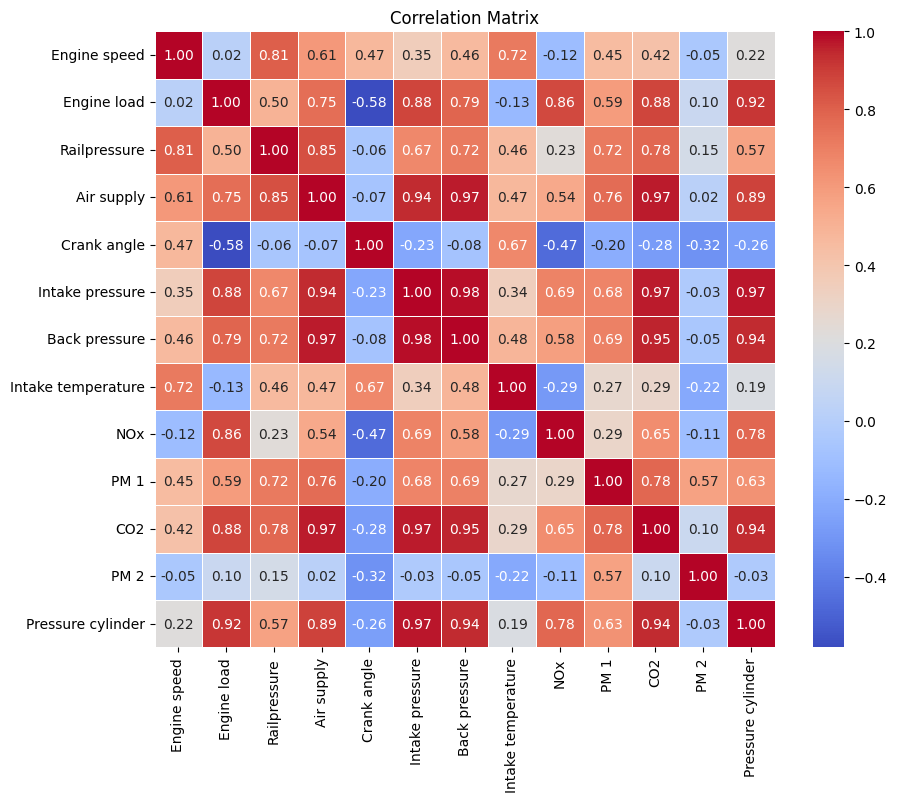

In [101]:
corr_matrix = data.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
#plt.show()

Significant Features based on Correlation Matrix:
NOx: ['Engine load', 'Air supply', 'Intake pressure', 'Back pressure']
PM 1: ['Engine load', 'Railpressure', 'Air supply', 'Intake pressure', 'Back pressure']
CO2: ['Engine load', 'Railpressure', 'Air supply', 'Intake pressure', 'Back pressure']
PM 2: ['Crank angle', 'Intake temperature']
Pressure cylinder: ['Engine load', 'Railpressure', 'Air supply', 'Intake pressure', 'Back pressure']


In [103]:
significant_features = {}
output_parameters = data.columns[-5:]

for output_param in output_parameters:
    significant_features[output_param] = []
    for i, input_param in enumerate(data.columns[:-5]):
        if abs(corr_matrix.loc[input_param, output_param]) > 0.5:
            significant_features[output_param].append(input_param)

significant_features['PM 2'] += ['Crank angle', 'Intake temperature']
# Display significant features for each output parameter
print("Significant Features based on Correlation Matrix:")
for output_param, features in significant_features.items():
    print(f"{output_param}: {features}")

# Prepare data with selected significant features for training
x_train_dict = {}
y_train_dict = {}
y_train = data.iloc[:, -5:]


for output_param, features in significant_features.items():
    x = data[features]
    x_train, x_test, y_train_param, y_test = train_test_split(x, y_train[output_param], test_size=0.3, random_state=42)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    x_train_dict[output_param] = x_train_scaled
    y_train_dict[output_param] = y_train_param


In [105]:
#Initialize and train models for each output parameter
rf_models = {}
svr_models = {}
lr_models = {}
gb_models = {}
nn_models = {}

for output_param in output_parameters:
    lr_models[output_param] = LinearRegression()
    lr_models[output_param].fit(x_train_dict[output_param], y_train_dict[output_param])

    rf_models[output_param] = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_models[output_param].fit(x_train_dict[output_param], y_train_dict[output_param])

    svr_models[output_param] = SVR(kernel='rbf', C=1.0, epsilon=0.2)
    svr_models[output_param].fit(x_train_dict[output_param], y_train_dict[output_param])

    gb_models[output_param] = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_models[output_param].fit(x_train_dict[output_param], y_train_dict[output_param])

    nn_models[output_param] = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
    nn_models[output_param].fit(x_train_dict[output_param], y_train_dict[output_param])


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Opti

In [116]:
# Evaluation function
def evaluate_model(model_dict, significant_features, X_test, y_test):
    total_mse = 0
    total_samples = len(y_test)
    for output_param, model in model_dict.items():
        features = significant_features[output_param]
        x_test_param = X_test[features]
        y_pred_param = model.predict(x_test_param)
        mse_param = mean_squared_error(y_test[output_param], y_pred_param)
        total_mse += mse_param * len(y_test[output_param])  # Accumulate MSE for each parameter
    avg_mse = total_mse / total_samples  # Compute the average MSE across all parameters
    print(f"Average Mean Squared Error: {avg_mse}")

# Test models directly on the entire test dataset
if 'NOx' in significant_features:
    evaluate_model(lr_models, significant_features, x_test, y_test)
evaluate_model(svr_models, significant_features, x_test, y_test)

print("\nGradient Boosting Regression:")
evaluate_model(gb_models, significant_features, x_test, y_test)

print("\nNeural Network Regression:")
evaluate_model(nn_models, significant_features, x_test, y_test)

c:\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


KeyError: 'NOx'